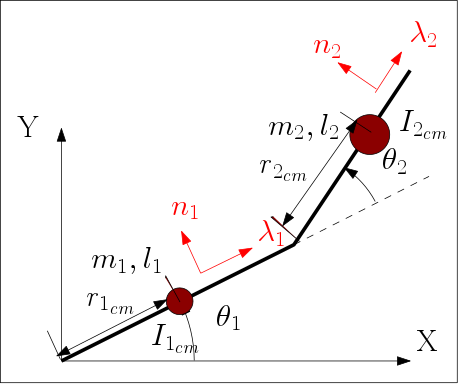

In [37]:
from IPython.display import Image 
from IPython.display import IFrame
IFrame("https://github.com/shyamashi/model_predictive_control/blob/master/src/2R%20manipulator%20theory/2R_manipulator_EOM.pdf", width=900, height=800)
Image(filename='/home/ar0058/Dropbox/Teaching Assistanship/Dynamics/Homework 3/2R_manip_2.png') 

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sympy import *
from sympy.physics.mechanics import *
from sympy.physics.vector import ReferenceFrame, Vector
from sympy.physics.vector import time_derivative
from sympy.tensor.array import Array

In [39]:
q1, q2 = dynamicsymbols('q1 q2')  # joint variables (same as theta_1, theta_2)
r1, r2 = dynamicsymbols('r1 r2')  # COM vector (same as r1_cm, r2_cm)
q1d, q2d = dynamicsymbols('q1 q2', 1)  # angular velocities
tau_1, tau_2, I1_zz, I2_zz, m1, m2 = symbols('tau_1 tau_2 I1_zz, I2_zz, m1, m2')  # Torques, Inertia about com Z axis, masses
l1, l2, g = symbols('l_1 l_2 g', positive=True)  # link lengths and gravity magnitude

m = [m1, m2]
grav = transpose(Matrix([[0, g, 0]]))

# Inertia tensor wrt centre of mass of each link
I1 = zeros(3, 3)
I1[2, 2] = I1_zz

I2 = zeros(3, 3)
I2[2, 2] = I2_zz

I = [I1, I2]

# COM vectors 
r11 = zeros(3, 1)
r11[0] = r1

r22 = zeros(3, 1)
r22[0] = r2

r = zeros(3, 2)
r[:, 0] = r11
r[:, 1] = r22

# DH parameters of the 2R manipulator
a = Array([0.0, l1, l2])
d = Array([0.0, 0.0, 0.0])
alpha = Array([0.0, 0.0, 0.0])

q = [q1, q2]
qd = [q1d, q2d]


In [40]:
# Symbolic forward kinematics from DH parameters
def fwd_kin_symbolic(q):
    q_i = Symbol("q_i")
    alpha_i = Symbol("alpha_i")
    a_i = Symbol("a_i")
    d_i = Symbol("d_i")
    T = Matrix([[cos(q_i), -sin(q_i), 0, a_i],
                [sin(q_i) * cos(alpha_i), cos(q_i) * cos(alpha_i), -sin(alpha_i), -sin(alpha_i) * d_i],
                [sin(q_i) * sin(alpha_i), cos(q_i) * sin(alpha_i), cos(alpha_i), cos(alpha_i) * d_i],
                [0, 0, 0, 1]])
    T_joint, T_i_i1 = [], []  #  T_joint and T_i_i1 are respectively the 4x4 transformation matrix relating i_th frame  wrt 0 and i+1 frame wrt i
    t = eye(4)
    for i in range(len(q)):
        temp = T.subs(alpha_i, alpha[i]).subs(a_i, a[i]).subs(d_i, d[i]).subs(q_i, q[i])
        t = t*temp
        T_joint.append(t)
        T_i_i1.append(temp)
    return T_joint, T_i_i1


In [41]:
# For detailed explanation of the formulas, please refer to https://nptel.ac.in/courses/112108093/6
def velocities(q):
    omega = Matrix.zeros(3, len(q)+1)
    joint_velocity = Matrix.zeros(3, len(q)+1)
    cm_vel = Matrix.zeros(3, len(q))
    _, t_i_i1 = fwd_kin_symbolic(q)  # T_i_i1 is the 4x4 transformation matrix of i+1 frame wrt to i
    for i in range(len(q)):
        R = t_i_i1[i][0:3, 0:3].transpose()
        omega[:, i+1] = R * omega[:, i] + Matrix([[0], [0], [qd[i]]])
        joint_velocity[:, i+1] = R * (joint_velocity[:, i] + omega[:, i].cross(t_i_i1[i][0:3, 3]))
    omega, joint_velocity = omega[:, 1:], joint_velocity[:, 1:]
    for i in range(len(q)):
        # cm_vel[:, i] = joint_velocity[:, i] + omega[:, i].cross(t_i_i1[i][0:3, 3]/2)
        cm_vel[:, i] = joint_velocity[:, i] + omega[:, i].cross(r[:, i])
    return omega, cm_vel, joint_velocity

In [42]:
def kinetic_energy(q):
    w, cm_vel, joint_velocity = velocities(q)
    K = 0
    for i in range(len(q)):
        K += 0.5*m[i]*cm_vel[:, i].dot(cm_vel[:, i]) + 0.5*w[:, i].dot(I[i]*w[:, i])
    return K


def potential_energy(q):
    T_joint, _ = fwd_kin_symbolic(q)  # T_joint is the 4x4 transformation matrix relating i_th frame  wrt to 0
    P = 0
    for i in range(len(q)):
        r_0_cm = T_joint[i][0:3, 0:3]*r[:, i] + T_joint[i][0:3, 3]  # com vector wrt 0
        P += m[i]*grav.dot(r_0_cm)
    return P

In [43]:
K = kinetic_energy(q)
P = potential_energy(q)
L = K - P  # Lagrangian
M = transpose(Matrix([[K]]).jacobian(qd)).jacobian(qd).applyfunc(trigsimp)  # Mass matrix
C = transpose(Matrix([[K]]).jacobian(qd)).jacobian(q) * Matrix(qd) - transpose(Matrix([[K]]).jacobian(q))  # Coriolis vector
C = C.applyfunc(trigsimp)
G = transpose(Matrix([[P]]).jacobian(q)).applyfunc(trigsimp)  # Gravity vector
# LM = LagrangesMethod(L, q)
# LM.form_lagranges_equations()
# print LM.mass_matrix.applyfunc(trigsimp)

In [44]:
G

Matrix([
[g*(l_1*m2*cos(q1(t)) + m1*r1(t)*cos(q1(t)) + m2*r2(t)*cos(q1(t) + q2(t)))],
[                                            g*m2*r2(t)*cos(q1(t) + q2(t))]])

In [45]:
M


Matrix([
[1.0*I1_zz + 1.0*I2_zz + 1.0*m1*r1(t)**2 + 1.0*m2*(l_1**2 + 2*l_1*r2(t)*cos(q2(t)) + r2(t)**2), 1.0*I2_zz + 1.0*m2*(l_1*cos(q2(t)) + r2(t))*r2(t)],
[                                            1.0*I2_zz + 1.0*m2*(l_1*cos(q2(t)) + r2(t))*r2(t),                       1.0*I2_zz + 1.0*m2*r2(t)**2]])

In [48]:
C

Matrix([
[-1.0*l_1*m2*(2*Derivative(q1(t), t) + Derivative(q2(t), t))*r2(t)*sin(q2(t))*Derivative(q2(t), t)],
[                                              1.0*l_1*m2*r2(t)*sin(q2(t))*Derivative(q1(t), t)**2]])

In [47]:
Matrix([P]).applyfunc(trigsimp)

Matrix([[g*(l_1*m2*sin(q1(t)) + m1*r1(t)*sin(q1(t)) + m2*r2(t)*sin(q1(t) + q2(t)))]])